In [1]:
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import colors

import astropy.io.fits as pyfits
import astropy.wcs as wcs

import os
import time

from scipy.signal import decimate

In [2]:
## import functions
import GMM_plot_library as pGMM
import GMM_functions as fGMM
import velocity_axis_datacube as vax

# Gaussian Mixture model example
- Works for a 3D spectral datacube, clusters data cube based on spectra morphology (see Kabanovic+2020 for a description)
- Here, the GMM clustering is applied to RCW 79

In [3]:
#### User input ####

## input for the data file
path_file = 'data/'
name_file = 'RCW79_CII_PCA_20_8_0p5_clean.fits'
unit_integrated_intensity = '$\int$T$_{mb}$dv (K km s$^{-1}$)'

## plotting options 
dpi_val = 300
path_plots = 'plots/'
save_name = 'GMM_RCW79.pdf'

## input for the Gaussian Mixture Models
n_comps_min = 6#1
n_comps_max = 8#11

## information for the observational information
noise_rms_obs = 0.6 ## K
min_velocity = -70. ## km/s
max_velocity = -25. ## km/s
unit_intensity = "T$_{mb}$ (K)"
unit_z_axis = "v (km s$^{-1}$)"

## spectral resolutions of the resampled data (need to be higher than the native velocity resolution)
dv_resamps = [1., 1.5, 2.] ## in km/s

########################

## Execute the script

In [4]:
## get the data and header information
hdu = pyfits.open(path_file + name_file)
hdu.info()
data = hdu[0].data
header = hdu[0].header

## store the spectral information (in km/s)
dv = 0.001*header['CDELT3']
crval = 0.001*header['CRVAL3']
crpix = header['CRPIX3']
print(dv)

## store the WCS information
header_c = header.copy()
header_c['NAXIS'] = 2
del header_c['NAXIS3']
del header_c['CTYPE3']
del header_c['CRVAL3']
del header_c['CDELT3']
del header_c['CRPIX3']
del header_c['CROTA3']

w = wcs.WCS(header_c)

Filename: data/RCW79_CII_PCA_20_8_0p5_clean.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      42   (188, 188, 160)   float32   
0.5


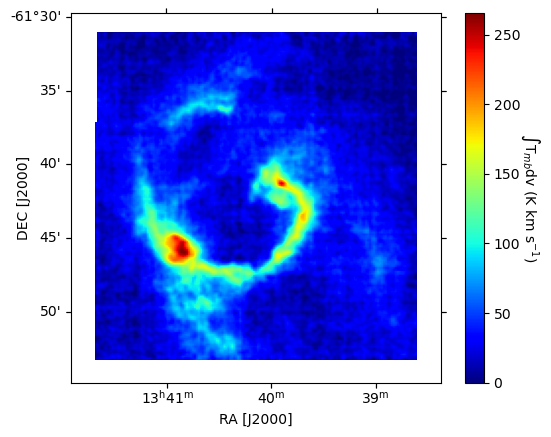

In [5]:
pGMM.inspect_intensity_map(data, dv, w, unit_integrated_intensity)

In [6]:
## reduce the data size along the z-axis to the region associated with emission
data_reduced = vax.reduce_z_axis_size(data, min_velocity, max_velocity, crval, dv, crpix)

The minimal pixel along the z-axis is: 40
The maximal pixel along the z-axis is: 130


In [7]:
'''
## loop over number of clusters for the GMM modeling
def fit_GMM(data_in):
    ## initialize the storage lists
    n_comps_list = []
    time_list = []
    bic_list = []
    bic_min = None
    best_model = None
    
    ## loop over the number of components to be fitted
    for i in range(n_comps_min, n_comps_max):
        ## perform the GMM fitting
        print("Calculating GMM for {index} number of components".format(index = i))
        start_time = time.time()
        temp_model = GaussianMixture(n_components = i, 
                                     init_params = 'kmeans', 
                                     covariance_type = 'full', 
                                     random_state = seed_val, 
                                     tol = threshold, 
                                     max_iter = gmm_iter).fit(data_in)
        end_time = time.time()
        time_list.append(end_time - start_time)
        
        ## calculate the Bayesian Information Criterion (BIC)
        temp_bic = temp_model.bic(data_in)
        
        ## store the best fitting model
        if(i == n_comps_min or temp_bic < bic_min):
            best_model = temp_model
            bic_min = temp_bic
        n_comps_list.append(i)
        bic_list.append(temp_bic)
        
    return n_comps_list, bic_list, time_list, best_model
'''

'\n## loop over number of clusters for the GMM modeling\ndef fit_GMM(data_in):\n    ## initialize the storage lists\n    n_comps_list = []\n    time_list = []\n    bic_list = []\n    bic_min = None\n    best_model = None\n    \n    ## loop over the number of components to be fitted\n    for i in range(n_comps_min, n_comps_max):\n        ## perform the GMM fitting\n        print("Calculating GMM for {index} number of components".format(index = i))\n        start_time = time.time()\n        temp_model = GaussianMixture(n_components = i, \n                                     init_params = \'kmeans\', \n                                     covariance_type = \'full\', \n                                     random_state = seed_val, \n                                     tol = threshold, \n                                     max_iter = gmm_iter).fit(data_in)\n        end_time = time.time()\n        time_list.append(end_time - start_time)\n        \n        ## calculate the Bayesian Informat

In [8]:
## prepare the data before the GMM loop
index_array, data_input = fGMM.prepare_data(data_reduced, min_velocity, max_velocity, crval, dv, crpix)

## fit the GMM
(n_comp_list_orig, bic_list_orig, time_list_orig, best_model_orig) = fGMM.fit_GMM(data_input, n_comps_min, n_comps_max)

# NEW FUNCTIONS TO THE GMM_FUNCTIONS.PY

Dimensions of resampled data: (90, 35344)
Calculating GMM for 6 number of components


/Users/larsbonne/Documents/code/Astro/GMM/GMM_functions.py:36: RuntimeWarning: All-NaN slice encountered
  max_vals = np.nanmax(data_resample, axis=0)


Calculating GMM for 7 number of components


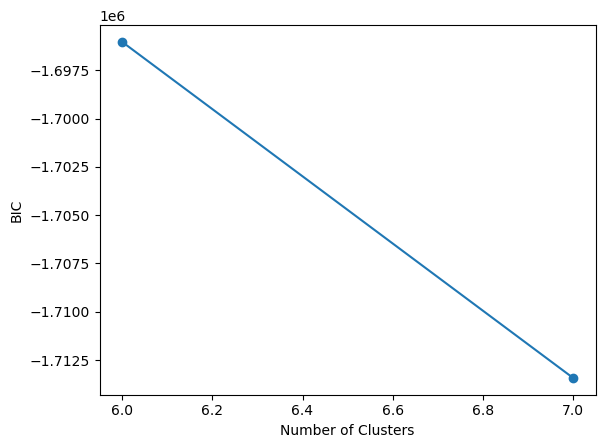

In [9]:
## plot BIC result as a function of the number of components
pGMM.plot_two_lists(n_comp_list_orig, bic_list_orig, "Number of Clusters", "BIC")

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


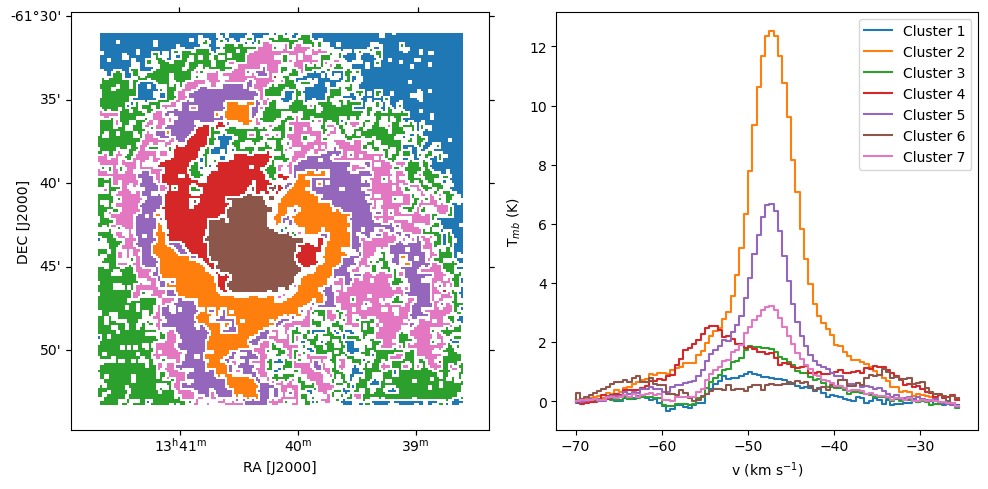

In [10]:
## Obtain the indices for the different clusters
cluster_inds = best_model_orig.predict(data_input)

## Map the spatial distribution of the different clusters
cluster_map = fGMM.map_spatial_cluster_distribution(cluster_inds, index_array, data.shape[2], data.shape[1])

## Create the velocity and resampled velocity array necessary for plotting
vel_arr = vax.create_velocity_array(min_velocity, max_velocity, dv)

## Plot the spectra associated with each cluster and indicate the spatial distribution of the identified spectral clusters
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w, plot_path = path_plots + save_name)

The routine is currently plotting cluster 0
The routine is currently plotting cluster 1
The routine is currently plotting cluster 2
The routine is currently plotting cluster 3
The routine is currently plotting cluster 4
The routine is currently plotting cluster 5
The routine is currently plotting cluster 6


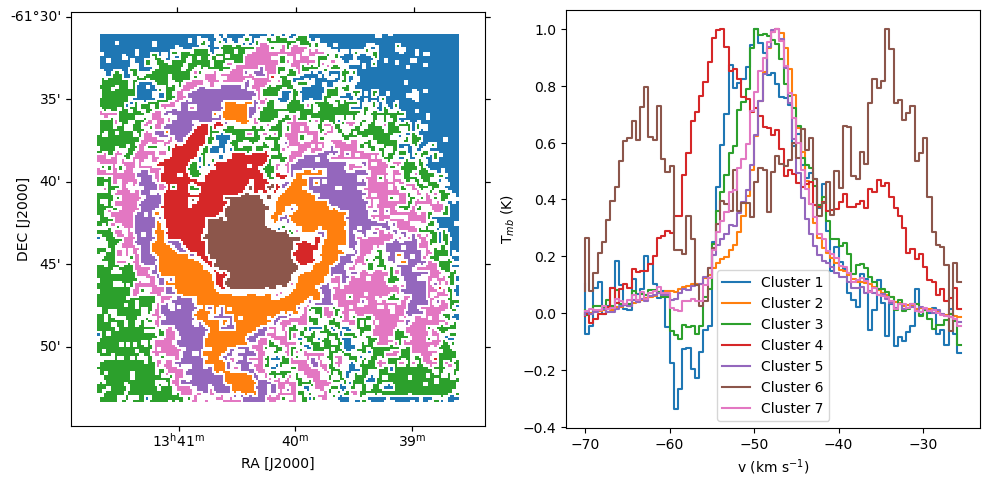

In [11]:
## Plot the normalized spectra associated with each cluster and their spatial distribution
pGMM.plot_clusters_and_spectra(data_reduced, cluster_map, vel_arr, w, normalize = True)

In [12]:
## Resample the data along the spectral axis to reduce the computational time of the GMM
## https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.decimate.html
## not a periodic system, so can't use scipy.signal.resample

## calculate the decimation factor
def resample_data(data_in, dv_resamp):
    factor = int(dv_resamp/dv + 0.5)
    print('\n')
    print("The number of spectral bins is reduced by a factor: {fact}".format(fact = factor))
    data_reduced_resamp = decimate(data_in, factor, axis = 0)
    print("new shape of the spectral cube: {shape}".format(shape = data_reduced_resamp.shape))
    
    return data_reduced_resamp

In [13]:
for dv_resamp in dv_resamps:
    data_resamp = resample_data(data_reduced, dv_resamp)
 
#vel_arr_resamp = vax.create_velocity_array(min_velocity, max_velocity, dv_resamp)



The number of spectral bins is reduced by a factor: 2
new shape of the spectral cube: (45, 188, 188)


The number of spectral bins is reduced by a factor: 3
new shape of the spectral cube: (30, 188, 188)


The number of spectral bins is reduced by a factor: 4
new shape of the spectral cube: (23, 188, 188)
